In [62]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [63]:
train = pd.read_csv('images/written_name_train_v2.csv')
valid = pd.read_csv('images/written_name_validation_v2.csv')
test = pd.read_csv('images/written_name_test_v2.csv')

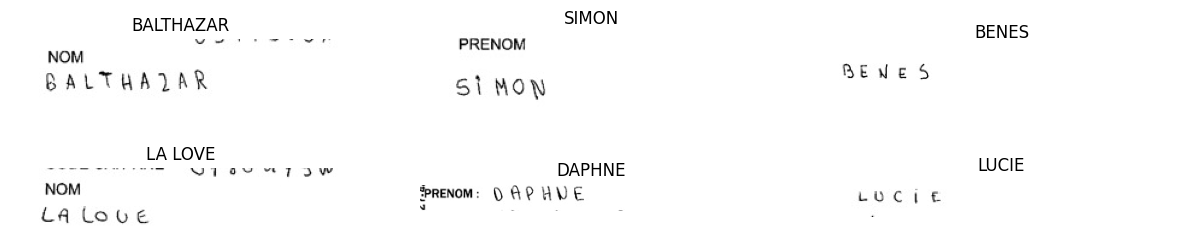

In [64]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'images/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [65]:
train_size = len(train)
print(f"Number of samples in the training set: {train_size}")

valid_size = len(valid)
print(f"Number of samples in the validation set: {valid_size}")

test_size = len(test)
print(f"Number of samples in the testing set: {test_size}")

Number of samples in the training set: 330961
Number of samples in the validation set: 41370
Number of samples in the testing set: 41370


In [66]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [67]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

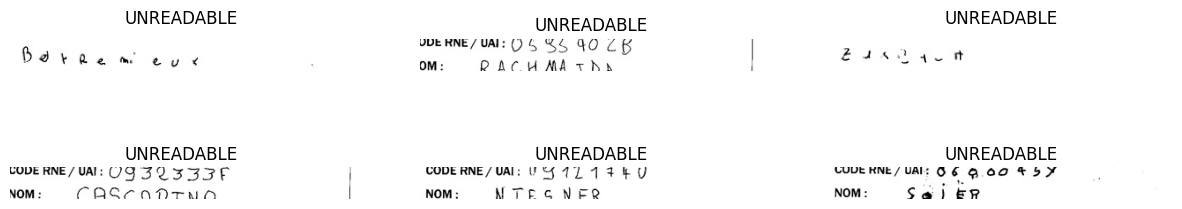

In [68]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'images/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [69]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [70]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [71]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [72]:
train_size = len(train)
print(f"Number of samples in the training set: {train_size}")

valid_size = len(valid)
print(f"Number of samples in the validation set: {valid_size}")

test_size = len(test)
print(f"Number of samples in the testing set: {test_size}")

Number of samples in the training set: 330294
Number of samples in the validation set: 41280
Number of samples in the testing set: 41370


In [73]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [74]:
train_size = 30000
valid_size= 3000

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = 'images/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = 'images/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [ ]:
print(f"Shape of preprocessed training data: {train_x.shape}")  # First value is the number of samples
print(f"Shape of preprocessed validation data: {valid_x.shape}")

Shape of preprocessed training data: (30000, 256, 64, 1)
Shape of preprocessed validation data: (3000, 256, 64, 1)


In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


Number of labels longer than 24 characters: 1
Percentage of long labels in training set: 0.00%


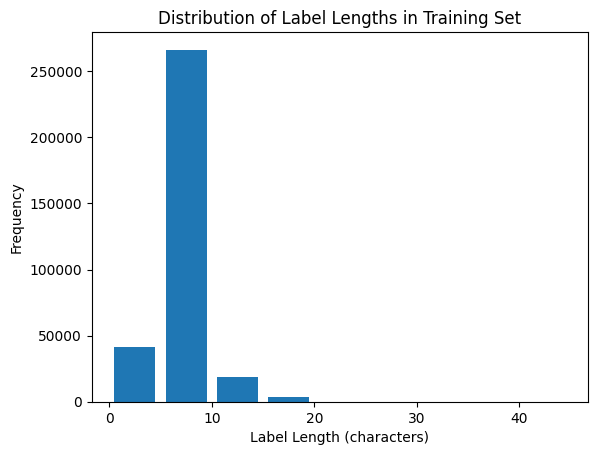

In [ ]:
# Define the threshold for a "long" label
threshold = 24

# Calculate the length of each label in the training set
train['label_length'] = train['IDENTITY'].apply(len)

# Find labels longer than the threshold
long_labels = train[train['label_length'] > threshold]

# Count how many labels are longer than the threshold
num_long_labels = len(long_labels)

# Calculate the percentage of long labels in the dataset
percentage_long_labels = (num_long_labels / len(train)) * 100

print(f"Number of labels longer than {threshold} characters: {num_long_labels}")
print(f"Percentage of long labels in training set: {percentage_long_labels:.2f}%")

# Optional: Plot a histogram of label lengths
train['label_length'].plot(kind='hist', bins=range(0, 50, 5), rwidth=0.8)
plt.title('Distribution of Label Lengths in Training Set')
plt.xlabel('Label Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Apply the same steps to the validation set
valid['label_length'] = valid['IDENTITY'].apply(len)
long_labels_valid = valid[valid['label_length'] > threshold]
num_long_labels_valid = len(long_labels_valid)
percentage_long_labels_valid = (num_long_labels_valid / len(valid)) * 100

print(f"Number of labels longer than {threshold} characters in validation set: {num_long_labels_valid}")
print(f"Percentage of long labels in validation set: {percentage_long_labels_valid:.2f}%")

Number of labels longer than 24 characters in validation set: 0
Percentage of long labels in validation set: 0.00%


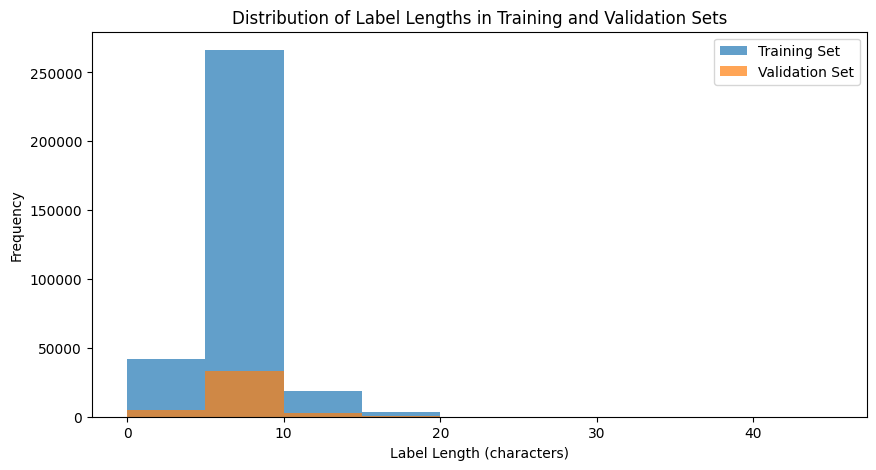

In [ ]:
# Plot histogram for both train and validation sets
plt.figure(figsize=(10, 5))

# Training set
plt.hist(train['label_length'], bins=range(0, 50, 5), alpha=0.7, label='Training Set')
# Validation set
plt.hist(valid['label_length'], bins=range(0, 50, 5), alpha=0.7, label='Validation Set')

plt.title('Distribution of Label Lengths in Training and Validation Sets')
plt.xlabel('Label Length (characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Remove rows with label length greater than 24 characters in-place
train = train[train['label_length'] <= 24]

# Reset index after filtering
train.reset_index(drop=True, inplace=True)

print(f"Modified training set size: {len(train)}")

Modified training set size: 330293


In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])   

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])  

In [ ]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Combine training and validation data
combined_x = np.concatenate((train_x, valid_x), axis=0)
combined_y = np.concatenate((train_y, valid_y), axis=0)

# Assuming train_label_len and valid_label_len are also combined
combined_label_len = np.concatenate((train_label_len, valid_label_len), axis=0)
combined_input_len = np.concatenate((train_input_len, valid_input_len), axis=0)

# Split the combined dataset into training and validation sets
train_X, valid_X, train_Y, valid_Y, train_input_len, valid_input_len, train_label_len, valid_label_len = train_test_split(
    combined_x,
    combined_y,
    combined_input_len,
    combined_label_len,
    test_size=0.0909,  # Adjust the split ratio as needed
    random_state=42
)

MemoryError: Unable to allocate 4.03 GiB for an array with shape (33000, 256, 64, 1) and data type float64

In [ ]:
from tensorflow.keras.regularizers import l2

# Input layer
input_data = Input(shape=(256, 64, 1), name='input')

# Convolutional layers with L2 regularization
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal', 
               kernel_regularizer=l2(0.001))(input_data)  # Lower L2 here
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal', 
               kernel_regularizer=l2(0.001))(inner)  # Lower L2 here
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.2)(inner)  # Reduced dropout for conv layers

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal', 
               kernel_regularizer=l2(0.001))(inner)  # Lower L2 here
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)

# Added 4th Convolutional Block
inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal', 
               kernel_regularizer=l2(0.001))(inner)  # Lower L2 here
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max4')(inner)
inner = Dropout(0.2)(inner)  # Reduced dropout for conv layers

# Added 5th Convolutional Block
inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal', 
               kernel_regularizer=l2(0.001))(inner)  # Lower L2 here
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max5')(inner)
inner = Dropout(0.2)(inner)  # Reduced dropout for conv layers

# Reshape for RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)  # Adjusted for larger feature map size
inner = Dense(64, activation='relu', kernel_initializer='he_normal', 
              kernel_regularizer=l2(0.001), name='dense1')(inner)  # Higher L2 here, more important layer

# Bidirectional LSTM layers with L2 regularization
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, 
                           kernel_regularizer=l2(0.001)), name='lstm1')(inner)  # Balanced Dropout and L2
inner = Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, 
                           kernel_regularizer=l2(0.001)), name='lstm2')(inner)  # Balanced Dropout and L2

# Output layer with L2 regularization
inner = Dense(num_of_characters, kernel_initializer='he_normal', 
              kernel_regularizer=l2(0.001), name='dense2')(inner)  # Regular L2 here
y_pred = Activation('softmax', name='softmax')(inner)

# Model definition
model = Model(inputs=input_data, outputs=y_pred)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 256, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 256, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 128, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 128, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 64, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max3 (MaxPooling2D)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 64, 8, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 8, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 8, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max4 (MaxPooling2D)             │ (None, 64, 4, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 4, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 64, 4, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 4, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 4, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,885,278 (14.82 MB)

 Trainable params: 3,883,294 (14.81 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Change to 'val_loss' if you prefer to monitor loss
    patience=5,                   # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,     # Restore the model weights from the epoch with the best value of the monitored quantity
)

# Create CSVLogger instance
csv_logger = CSVLogger('images/training_log.csv', append=False)

In [ ]:
model_final.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=Adam(learning_rate=0.0001)
)

In [ ]:
model_final.save("model_upto_50.h5")

In [ ]:
history = model_final.fit(
    x=[train_X, train_Y, train_input_len, train_label_len],
    y=train_output,
    validation_data=([valid_X, valid_Y, valid_input_len, valid_label_len], valid_output),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping, csv_logger]
)

Epoch 1/50


g:\GitHub\Handwritten_Image_Recognition\model\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input', 'gtruth_labels', 'input_length', 'label_length']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


ValueError: Creating variables on a non-first call to a function decorated with tf.function.